In [1]:
# Standard library imports
import sys
from os import listdir, mkdir
from os.path import join, exists

# Third party imports
import h5py
import json
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

from utils_plot import *


In [2]:
def read_static_data():
    hirid2_path = "/cluster/work/grlab/clinical/hirid2/research"
    hirid1_path = ("/cluster/work/grlab/clinical/Inselspital/DataReleases"
                   "/01-19-2017/InselSpital")
    df = pd.read_hdf(join(hirid2_path, "1a_hdf5_clean", "v8", "static.h5"))
    
    age_bin = np.array([16,31,46,66,81,101])
    age_lbl = np.array(["{}-{}".format(age_bin[i],age_bin[i+1]-1) for i in range(len(age_bin)-1)])
    df.loc[:,"Age"] = df["Age"].apply(lambda x: age_lbl[np.where((x-age_bin)>=0)[0][-1]])
    
    apa_name = pd.read_csv(join(hirid1_path, "misc_derived", 
                                "apache_metagroup_name.csv"))
    apa_name = apa_name.set_index("meta_group")
    df = df.replace({"APACHEPatGroup": {x: apa_name.loc[int(x)].Name 
                                        for x in apa_name.index}})
    
    df = df.replace({"Emergency": {0: "Not emergency", 
                                   1: "Emergency"}})
    df = df.replace({"Discharge": {2: "Alive at discharge", 
                                   4: "Dead at discharge"}})

    return df

In [3]:
def read_static_data():
    hirid2_path = "/cluster/work/grlab/clinical/hirid2/research"
    hirid1_path = ("/cluster/work/grlab/clinical/Inselspital/DataReleases"
                   "/01-19-2017/InselSpital")
    df = pd.read_hdf(join(hirid2_path, "1a_hdf5_clean", "v8", "static.h5"))
    
    age_bin = np.array([16,31,46,66,81,101])
    age_lbl = np.array(["{}-{}".format(age_bin[i],age_bin[i+1]-1) for i in range(len(age_bin)-1)])
    df.loc[:,"Age"] = df["Age"].apply(lambda x: age_lbl[np.where((x-age_bin)>=0)[0][-1]])
    
    apa_name = pd.read_csv(join(hirid1_path, "misc_derived", 
                                "apache_metagroup_name.csv"))
    apa_name = apa_name.set_index("meta_group")
    df = df.replace({"APACHEPatGroup": {x: apa_name.loc[int(x)].Name 
                                        for x in apa_name.index}})
    
    df = df.replace({"Emergency": {0: "Not emergency", 
                                   1: "Emergency"}})
    df = df.replace({"Discharge": {2: "Alive at discharge", 
                                   4: "Dead at discharge"}})

    return df

In [4]:
def read_alarm_files(res_path, 
                     res_dir, 
                     data_split, 
                     configs, 
                     fixed_rec=0.9, 
                     RANDOM=False):
    
    keyexp1 = ("rand_" if RANDOM else "") + get_keystr(configs)
    keyexp2 = "_rec-{}.".format(fixed_rec)
    # print(keyexp1)

    alarm_path = join(res_path, res_dir, "{}_alarm".format(data_split))
    alarm_file = join(alarm_path, "{}{}h5".format(keyexp1, keyexp2))
    if exists(alarm_file):
        df = pd.read_hdf(alarm_file, "data")
    else:
        batches = [f for f in listdir(alarm_path) if ((keyexp1 in f) 
                                                      and (keyexp2 in f) 
                                                      and ("batch" in f))]
        print("Merging alarm files")
        df = []
        for i, f in enumerate(batches):
            with h5py.File(join(alarm_path, f), mode="r") as tmp:
                pids = [k for k in tmp.keys() if k!="data"]
            df.extend([pd.read_hdf(join(alarm_path, f), p) for p in pids])
            print(f)
            print("Finish reading batch %d"%(i+1))

        df = pd.concat(df).reset_index()
        df.to_hdf(alarm_file, "data", complevel=5, complib="blosc:lz4")
        print("Finish writing")
    return df

In [5]:
def get_sep_day(df_alarm, day_sep):
    
    df_alarm_new = []
    for df in df_alarm:
        tmp = df.set_index(["PatientID", "Datetime"])
        tmp = tmp.merge(day_sep, how='outer', left_index=True, right_index=True)
        tmp = tmp.reset_index()
        tmp = tmp.sort_values(["PatientID", "Datetime"])
        tmp.loc[:,"day_sep"] = tmp["day_sep"].fillna(method="ffill")
        tmp.loc[:,"weekday"] = tmp["Datetime"].dt.weekday
        
        tmp.loc[:,"InEvent"] = 0
        tmp.loc[:,"Onset"] = tmp.Onset.fillna(False)
        tmp.loc[:,"EventEnd"] = tmp.EventEnd.fillna(False)
        for p in tmp.PatientID.unique():
            tmp_p = tmp[tmp.PatientID==p]
            if tmp_p.Onset.sum()==0:
                continue
            
            dts_ons = tmp_p["Datetime"][tmp_p.Onset==True].values
            dts_end = tmp_p["Datetime"][tmp_p.EventEnd==True].values
            for i in range(len(dts_ons)):
                idx_in_event = tmp_p.index[(tmp_p["Datetime"]>=dts_ons[i])
                                           &(tmp_p["Datetime"]<=dts_end[i])]
                tmp.loc[idx_in_event,"InEvent"] = 1
                
        df_alarm_new.append(tmp)
        
    return df_alarm_new

In [6]:
plt.style.use("paper.mplstyle")
cm = 1/2.54 
h=5.8
w=6

In [7]:
renal_res_path = "/cluster/work/grlab/clinical/hirid2/research/kdigo_analysis/"
renal_fig_path = "paper_figures_renal"
if not exists(renal_fig_path):
    mkdir(renal_fig_path)

In [8]:
dataset="hirid"
model_dict = {
    "Time-stacked GBDT-snapshot": "var28_simple_features_separate_combined_calibrated_lgbm_test_FromZero",
     "LSTM": "var28_lstm_test_FromZero"
    # "Time-stacked GBDT-history": "var28_complex_features_separate_combined_calibrated_lgbm_test_FromZero",
    # "Joint GBDT-snapshot": "var28_simple_features_lgbm_recompute_test_FromZero",
    # "Joint GBDT-history": "var28_complex_features_lgbm_recompute_test_FromZero",
    # "Time-stacked GBDT-snapshot": "var28_simple_features_separate_combined_calibrated_extval_retrain_lgbm_test_FromZero",
     # "LSTM": "var28_simple_features_extval_retrain_lstm_test_FromZero"
}
fixed_rec = 0.8
if dataset=="hirid":
    data_splits = ["temporal_{}".format(i) for i in range(1,6)]
else:
    data_splits = ["random_{}".format(i) for i in range(1,6)]
    

ts_h = 8
alarm_sys_configs = dict()
alarm_sys_configs.update(t_mingap_m=0)
alarm_sys_configs.update(t_reset_m=720)
alarm_sys_configs.update(t_delta_m=0)
alarm_sys_configs.update(t_window_m=2880)
alarm_sys_configs.update(t_window_h=48)
alarm_sys_configs.update(t_silence_m=ts_h*60)

In [9]:
alarm_dict = dict()
for model, res_dir in model_dict.items():
    alarm_dict.update({model: [read_alarm_files(renal_res_path,
                                                res_dir,
                                                dsplit,
                                                alarm_sys_configs,
                                                fixed_rec=fixed_rec
                                               ) for dsplit in data_splits]})

In [10]:
if dataset=="hirid":
    static = read_static_data()
    static = static.set_index("PatientID")
    static.loc[:,"DischargeTime"] = np.nan
    for df in alarm_dict[[k for k in alarm_dict.keys()][0]]:
        tmp = df[["PatientID","DiscRelDatetime"]].drop_duplicates("PatientID")
        tmp.loc[:,"DiscRelDatetime"] = tmp["DiscRelDatetime"].astype(int)
        tmp = tmp.set_index("PatientID")
        for p in tmp.index:
            reldt_disc = tmp.loc[p,"DiscRelDatetime"]
            static.loc[int(p),"DischargeTime"] = (static.loc[int(p),"AdmissionTime"] 
                                             + np.timedelta64(int(reldt_disc), "s") )
    static.loc[:,"DischargeTime"] = pd.to_datetime(static["DischargeTime"])
    static = static[static.DischargeTime.notnull()]
else:
    static = pd.read_hdf("/cluster/work/grlab/clinical/hirid2/research/3_merged/MIMIC-IV/static.h5")
    static.loc[:,"AdmissionTime"] = np.nan
    for df in alarm_dict[[k for k in alarm_dict.keys()][0]]:
        df.loc[:,"AdmissionTime"] = df.Datetime.values-[np.timedelta64(int(x),"s") for x in df.RelDatetime.values]
        adm_t = df.drop_duplicates("PatientID", keep="last")[["PatientID", "AdmissionTime"]]
        adm_t.loc[:,"PatientID"] = adm_t.PatientID.astype(int)
        adm_t = adm_t.set_index("PatientID")
        static.loc[adm_t.index, "AdmissionTime"] = adm_t.AdmissionTime.values
    for df in alarm_dict[[k for k in alarm_dict.keys()][0]]:
        tmp = df[["PatientID","DiscRelDatetime"]].drop_duplicates("PatientID")
        tmp.loc[:,"DiscRelDatetime"] = tmp["DiscRelDatetime"].astype(int)
        tmp = tmp.set_index("PatientID")
        for p in tmp.index:
            reldt_disc = tmp.loc[p,"DiscRelDatetime"]
            static.loc[int(p),"DischargeTime"] = (static.loc[int(p),"AdmissionTime"] 
                                             + np.timedelta64(int(reldt_disc), "s") )
    static.loc[:,"DischargeTime"] = pd.to_datetime(static["DischargeTime"])
    static = static[static.DischargeTime.notnull()]
    static = static.reset_index().rename(columns={"stay_id":"PatientID"}).set_index("PatientID")

In [11]:
day_sep = []
static.loc[:,"AdmissionTime_round"] = pd.to_datetime(static["AdmissionTime"]).dt.floor(freq="1D")
static.loc[:,"DischargeTime_round"] = pd.to_datetime(static["DischargeTime"]).dt.floor(freq="1D")

for p in static.index:
    
    start = static.loc[p,"AdmissionTime"]
    start_round = static.loc[p,"AdmissionTime_round"]
    
    end = static.loc[p, "DischargeTime"]
    end_round = static.loc[p,"DischargeTime_round"]
    
    if len(pd.date_range(start_round, end_round, freq="1D")) == 0:
        continue
        
    rng = pd.date_range(start_round, end_round, freq="1D").to_frame(name="Datetime")
    rng.loc[:,"PatientID"] = p
    rng.loc[:,"day_sep"] = np.arange(len(rng))
    
    day_sep.append(rng)
    
day_sep = pd.concat(day_sep).reset_index(drop=True)
day_sep = day_sep.set_index(["PatientID", "Datetime"])

In [12]:
for model, df_alarm in alarm_dict.items():
    alarm_dict.update({model: get_sep_day(df_alarm, day_sep)})

In [13]:
for model, df_alarm in alarm_dict.items():
    alarm_dict.update({model: [df_alarm[k][df_alarm[k].DiscRelDatetime.notnull()].drop_duplicates() for k in range(len(df_alarm))]})

In [14]:
all_alarm_freq = []
for model, df_alarm in alarm_dict.items():
    alarm_freq = []
    for i, df in enumerate(df_alarm):
        wd_wi_onset = {k: [] for k in range(7)}
        wd_wo_onset = {k: [] for k in range(7)}

        for p in df.PatientID.unique():
            tmp_p = df[df.PatientID==p]
            
            for day in tmp_p.day_sep.unique():
                tmp_pd = tmp_p[tmp_p.day_sep==day]
                tmp_pd_next = tmp_p[(tmp_p.day_sep==(day+1))|(tmp_p.day_sep==(day+2))]
                
                wd = tmp_pd["weekday"].iloc[0]
                if tmp_pd_next.InEvent.sum()==0:
                    wd_wo_onset[wd].append(tmp_pd)
                else:
                    wd_wi_onset[wd].append(tmp_pd)
                    
        for wd in wd_wi_onset.keys():
            cnt_pa_wd_wi_onset = len(wd_wi_onset[wd])
            cnt_pa_wd_wo_onset = len(wd_wo_onset[wd])

            wi_onset_aggr = pd.concat(wd_wi_onset[wd])[["Alarm", "TrueAlarm"]]
            wo_onset_aggr = pd.concat(wd_wo_onset[wd])[["Alarm", "TrueAlarm"]]
            
            av_alarm_wi_onset = (wi_onset_aggr.sum(axis=0) 
                                   / cnt_pa_wd_wi_onset)
            
            
            av_alarm_wo_onset = (wo_onset_aggr.sum(axis=0) 
                                 / cnt_pa_wd_wo_onset)

            alarm_freq.append([i, wd, 
                               av_alarm_wi_onset['Alarm'], 
                               av_alarm_wi_onset['TrueAlarm'], 
                               av_alarm_wo_onset['Alarm'], 
                               av_alarm_wo_onset['TrueAlarm']])
            
    id_vars = ["Split", "WeekDay"]
    va_vars = ["at least one onset occurring\nin the next two days", 
               "# true alarms when at least one onset occurs in the next two days", 
               "no onset in the next two days",
               "# true alarms when no onset occurs in the next two days"]
    alarm_freq = pd.DataFrame(alarm_freq, columns=id_vars+va_vars)
    alarm_freq = pd.melt(alarm_freq, id_vars=id_vars, value_vars=va_vars)
    alarm_freq.loc[:,"Model"] = model
    all_alarm_freq.append(alarm_freq)
    
all_alarm_freq = pd.concat(all_alarm_freq).reset_index(drop=True)

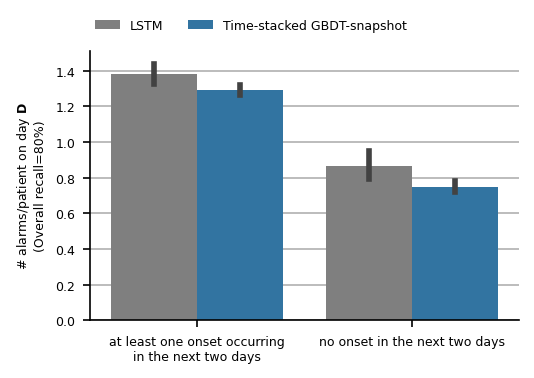

In [15]:
plt.figure(figsize=(w*1.5*cm, h*1.1*cm))
sns.barplot(data=all_alarm_freq, x="variable", y="value", hue="Model", 
            hue_order=["LSTM", "Time-stacked GBDT-snapshot"],
            palette=["C7", "C0"], 
            order=np.array(va_vars)[[0,2]], zorder=2)
plt.grid(axis="y")
plt.legend(bbox_to_anchor=(0., 1.05, 1., .105), loc="lower left",
           ncols=2, borderaxespad=0.)
plt.ylabel("# alarms/patient on day $\mathbf{D}$\n(Overall recall=%g%%)"%(fixed_rec*100))
plt.xlabel("")
plt.tight_layout()
plt.savefig(join(renal_fig_path,"mimic_alarm_load"))
plt.show()

In [16]:
# plt.figure(figsize=(w*1.5*cm, h*1.1*cm))
# sns.barplot(data=all_alarm_freq.groupby(["Model", "Split", "variable"]).mean().reset_index(), x="variable", y="value", hue="Model",
#             order=np.array(va_vars)[[0,2]], zorder=2)
# plt.grid(axis="y")
# plt.legend(bbox_to_anchor=(0., 1.05, 1., .105), loc="lower left",
#            ncols=2, borderaxespad=0.)
# plt.ylabel("# alarms/patient on day $\mathbf{D}$\n(Overall recall=%g%%)"%(fixed_rec*100))
# plt.xlabel("")
# plt.tight_layout()
# plt.savefig(join(renal_fig_path,"hirid_alarm_load_stacked_snapshot"))
# plt.show()

In [17]:
for k, v in alarm_dict.items():
    print(k,[vv.Alarm.sum() for vv in v])
    print(k, "%2.3f"%np.mean([vv.Alarm.sum() / (np.maximum(vv.drop_duplicates("PatientID", keep="last").DiscRelDatetime-2*3600,0).sum() / 3600 / 24) for vv in v])) 
    print(k, "%2.3f"%np.std([vv.Alarm.sum() / (np.maximum(vv.drop_duplicates("PatientID", keep="last").DiscRelDatetime-2*3600,0).sum() / 3600 / 24) for vv in v])) 

Time-stacked GBDT-snapshot [5971, 6025, 6036, 5998, 5648]
Time-stacked GBDT-snapshot 0.742
Time-stacked GBDT-snapshot 0.018
LSTM [11444, 6223, 6069, 5730, 5578]
LSTM 0.876
LSTM 0.279
